In [2]:
import numpy as np
import pandas as pd
from copy import deepcopy
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
t_player_starts = [2,7]
st_time_labels = ['S1','S2']
minute_suffix = ['nd','th']
traffic_lanes = ['T1','T2']

t_lights_on = 5 #mins : time duration of traffic lights
T1_on_frq = 10 # every 5 minutes T1 traffic light is on
T2_on_frq = 30 # every 30 minutes T2 traffic light is on

st_to_mid = 10 #mins : time taken to middle from start point
mid_to_top = 10 #mins : time taken from middle to top of the road

# Note that time from the middle of the road to the starting point is st_to_mid+2*mid_to_top
n_mins = 1000 #mins
n_days = 365 #days
trial_period = 90 #days

n_rounds = 4
operate_times = lambda on_freq : np.arange(start=0,stop=n_mins, step=on_freq)

T1_start_end = np.concatenate(
    (operate_times(T1_on_frq).reshape((-1,1)),
    operate_times(T1_on_frq).reshape((-1,1))+t_lights_on),
    axis=1
    )

T2_start_end = np.concatenate(
    (operate_times(T2_on_frq).reshape((-1,1)),
    operate_times(T2_on_frq).reshape((-1,1))+t_lights_on),
    axis=1
    )


traffic_lane_st_end = {'T1':T1_start_end, 'T2':T2_start_end}

In [57]:
def get_waiting_time(t_light_st_end, t_mid):
    greater_lighton = (t_light_st_end[:,0]<=t_mid).reshape((-1,1))
    less_lighton = (t_light_st_end[:,1]>=t_mid).reshape((-1,1))
    combined_conditions = np.concatenate((greater_lighton,less_lighton), axis=1)
    traffic_times = t_light_st_end[np.all(combined_conditions, axis=1)]

    if len(traffic_times)>0:
        traffic_start, traffic_end = traffic_times[0]

        wait_time = traffic_end-t_mid

        if wait_time==0:
            return 1
        return wait_time

    else:
        return 0
    


def posterior_prob(st_label, counts_dct):

    if counts_dct[f'{st_label}']==0:
        return (np.nan, np.nan)
    return (counts_dct[f'~T1{st_label}']/counts_dct[f'{st_label}'],
            counts_dct[f'~T2{st_label}']/counts_dct[f'{st_label}'])

def prior_prob(counts_dct):
    denominator = (counts_dct['S1']+counts_dct['S2'])
    if denominator==0:
        return (np.nan,np.nan)
    p_not_T1 = (counts_dct['~T1S1']+counts_dct['~T1S2'])/denominator
    p_not_T2 = (counts_dct['~T2S1']+counts_dct['~T2S2'])/denominator

    return (p_not_T1,p_not_T2)

In [65]:
count_tracker = {
    'T1S1':0,
    'T1S2':0,
    '~T1S1':0,
    '~T1S2':0,
    'T2S1':0,
    'T2S2':0,
    '~T2S1':0,
    '~T2S2':0,
    'T1':0,
    'T2':0,
    '~T1':0,
    '~T2':0,
    'S1':0,
    'S2':0
}

daywise_record = {}
time_taken_record = {st_label:{'day':[],'time':[]} for st_label in st_time_labels}


for day in range(1,n_days+1):
    st_time = random.sample(t_player_starts, k=1)[0]
    st_label = st_time_labels[t_player_starts.index(st_time)]
    
    curr_place = 'start'
    t_taken = 0
    t_to_mid = st_time+st_to_mid
    
    rounds = 0
    while rounds<=n_rounds:
        count_tracker[st_label]+=1

        if day<=trial_period:
            chosen_lane = random.sample(traffic_lanes, k=1)[0]
        else:
            chosen_lane = random.choices(population=traffic_lanes, weights=posterior_prob(st_label, counts_dct=count_tracker))[0]

        t_taken+=t_to_mid
        curr_place = 'middle'

        traf_light_time = get_waiting_time(traffic_lane_st_end[chosen_lane], t_taken)
        t_taken+=traf_light_time
        
        if traf_light_time==0:
            mod_chosen_lane = f'~{chosen_lane}'
        else:
            mod_chosen_lane = chosen_lane

        count_tracker[f'{mod_chosen_lane}{st_label}']+=1
        count_tracker[mod_chosen_lane]+=1
        

        t_taken+=(2*mid_to_top+st_to_mid)
        curr_place = 'start'
        rounds+=1
    
    daywise_record[day] = deepcopy(count_tracker)
    time_taken_record[st_label]['day'].append(day)
    time_taken_record[st_label]['time'].append(t_taken-st_time)


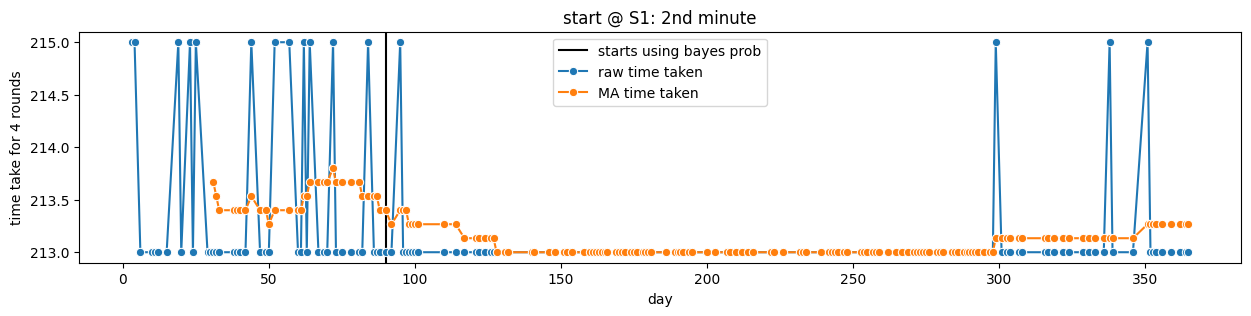

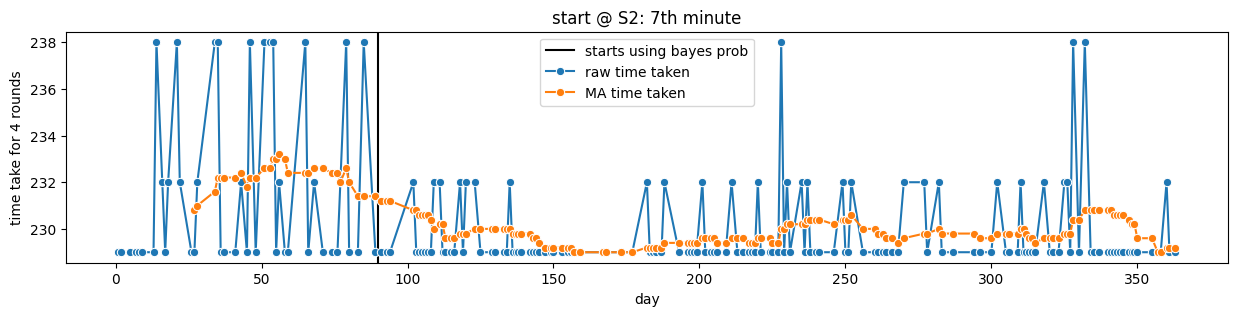

In [92]:

for index, st_lab in enumerate(st_time_labels):
    start_t_str = f'{st_lab}: '+str(t_player_starts[index])+minute_suffix[index]

    plt.figure(figsize=(15,3))
    plt.axvline(trial_period, color = 'black',label='starts using bayes prob')
    plot_df = pd.DataFrame(time_taken_record[st_lab])
    plot_df['ma_time']  = plot_df['time'].rolling(15).mean()
    sns.lineplot(data=plot_df,x='day',y='time', marker='o', label=f'raw time taken')
    sns.lineplot(data=plot_df,x='day',y='ma_time', marker='o', label=f'MA time taken')
    
    plt.title(f'start @ {start_t_str} minute')
    plt.ylabel(f'time take for {n_rounds} rounds')

In [68]:


posterior_variation = {'day':[],'~T1|S1':[],'~T1|S2':[],'~T2|S1':[], '~T2|S2':[]}
priors_variation = {'day':[],'~T1':[],'~T2':[],}
for day, counts_ in daywise_record.items():
    posterior_variation['day'].append(day)
    priors_variation['day'].append(day)
    for st_lab in ['S1','S2']:
        T1_prob , T2_prob = posterior_prob(st_lab, counts_dct=counts_)
        posterior_variation[f'~T1|{st_lab}'].append(T1_prob)
        posterior_variation[f'~T2|{st_lab}'].append(T2_prob)
    
    p_not_T1, p_not_T2 = prior_prob(counts_)
    priors_variation['~T1'].append(p_not_T1)
    priors_variation['~T2'].append(p_not_T2)
    
posterior_variation_df = pd.DataFrame(posterior_variation).fillna(0)
priors_variation_df = pd.DataFrame(priors_variation).fillna(0)


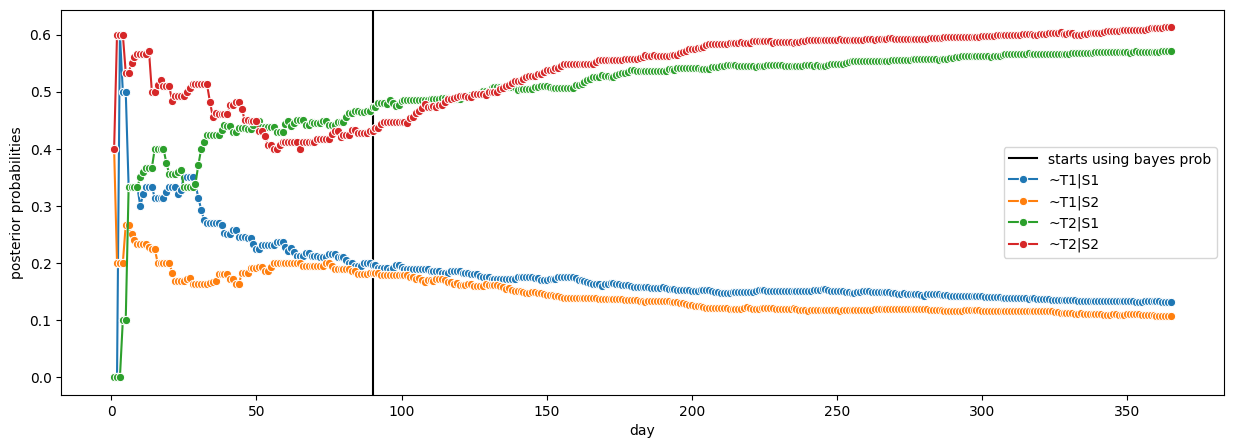

In [81]:
plt.figure(figsize=(15,5))
plt.axvline(trial_period, color = 'black',label='starts using bayes prob')
for prb in posterior_variation_df.columns[1:]:
 sns.lineplot(data=posterior_variation_df,x='day',y=prb, label=prb, marker='o')
 plt.ylabel('posterior probabilities')


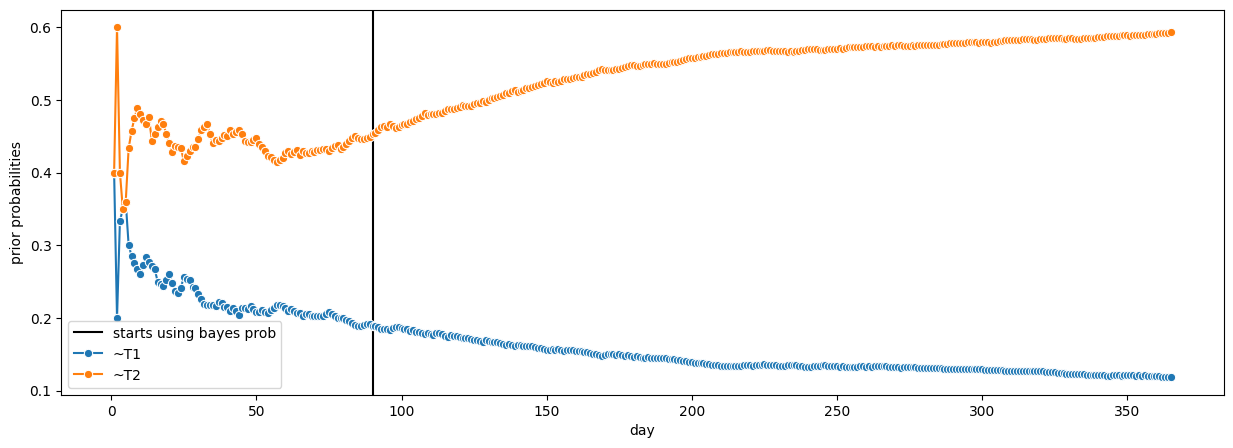

In [82]:
plt.figure(figsize=(15,5))
plt.axvline(trial_period, color = 'black',label='starts using bayes prob')
for prb in priors_variation_df.columns[1:]:
 sns.lineplot(data=priors_variation_df,x='day',y=prb, label=prb, marker='o')
 plt.ylabel('prior probabilities')